# Physics-informed DeepONet (witout Data; only IC + ODE)

- https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets

In [ ]:
import os

import jax.numpy as jnp
from jax import random, grad, vmap, jit, config
from jax.nn import relu
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint

import matplotlib.pyplot as plt
import itertools
from functools import partial
from tqdm import trange
from torch.utils.data import Dataset

In [ ]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply


# Data generator
class DataGenerator(Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u  # input sample
        self.y = y  # location
        self.s = s  # labeled data evaluated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs
    

# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, length_scale = params
    diffs = jnp.expand_dims(x1 / length_scale, 1) - \
            jnp.expand_dims(x2 / length_scale, 0)
    r2 = jnp.sum(diffs**2, axis=2)
    return output_scale * jnp.exp(-0.5 * r2)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, length_scale=0.2, m=100, P=1, Q=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = jnp.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = jnp.linalg.cholesky(K + jitter*jnp.eye(N))
    gp_sample = jnp.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: jnp.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = jnp.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0, jnp.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = jnp.tile(u, (P, 1))

    # training data for the residual
    u_r_train = jnp.tile(u, (Q, 1))
    y_r_train = jnp.linspace(0, 1, Q)
    s_r_train = vmap(u_fn, in_axes=(None,0))(0.0, y_r_train)

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, length_scale=0.2, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = jnp.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = jnp.linalg.cholesky(K + jitter*jnp.eye(N))
    gp_sample = jnp.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function  
    u_fn = lambda x, t: jnp.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = jnp.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = jnp.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = jnp.tile(u, (P, 1))

    return u, y, s 

# Geneate training data corresponding to N input sample
def generate_training_data(key, length_scale, N, m, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_training_data(key, length_scale, m, P, Q))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = jnp.float32(u_train.reshape(N * P,-1))
    y_train = jnp.float32(y_train.reshape(N * P,-1))
    s_train = jnp.float32(s_train.reshape(N * P,-1))

    u_r_train = jnp.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = jnp.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = jnp.float32(s_r_train.reshape(N * Q,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, length_scale, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, length_scale, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = jnp.float32(u.reshape(N * P,-1))
    y = jnp.float32(y.reshape(N * P,-1))
    s = jnp.float32(s.reshape(N * P,-1))

    config.update("jax_enable_x64", False)
    return u, y, s

In [ ]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=jnp.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=jnp.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=1000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()
        
        # Loggers
        self.loss_log = []
        self.loss_operator_log = []
        self.loss_physics_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = jnp.sum(B * T)
        return outputs
    
    # Define ODE/PDE residual
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y
    
    # Define operator loss
    def loss_operator(self, params, batch):
        # Fetch data
        # inputs: (u, y), shape = (N, m), (N, 1)
        # outputs: s, shape = (N, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss

    # Define physics loss
    def loss_physics(self, params, batch):
        # Fetch data
        # inputs: (u_r, y_r), shape = (NxQ, m), (NxQ, 1)
        # outputs: s_r, shape = (NxQ, 1)
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0))(params, u, y)
        # Compute loss
        loss = jnp.mean((outputs.flatten() - pred.flatten())**2)
        return loss    
    
    # Define total loss
    def loss(self, params, operator_batch, physics_batch):
        loss_operator = self.loss_operator(params, operator_batch)
        loss_physics = self.loss_physics(params, physics_batch)
        loss = loss_operator + loss_physics
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, operator_batch, physics_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, operator_batch, physics_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, operator_dataset, physics_dataset, nIter = 10000):
        # Define the data iterator
        operator_data = iter(operator_dataset)
        physics_data = iter(physics_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            operator_batch= next(operator_data)
            physics_batch = next(physics_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, operator_batch, physics_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, operator_batch, physics_batch)
                loss_operator_value = self.loss_operator(params, operator_batch)
                loss_physics_value = self.loss_physics(params, physics_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_operator_log.append(loss_operator_value)
                self.loss_physics_log.append(loss_physics_value)

                # Print losses during training
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_operator' : loss_operator_value, 
                                  'loss_physics': loss_physics_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

In [ ]:
m = 100     # Number of locations for evaluating the input functions u

In [ ]:
# Initialize model

branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]

model = PI_DeepONet(branch_layers, trunk_layers)

# Before training

In [ ]:
key_test = random.PRNGKey(0)
l_test = 0.2
N_test = 2
m_test = m    
P_test = 100

u_test, y_test, s_test = \
    generate_test_data(key_test, l_test, N_test, m_test, P_test)

In [ ]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:, None]
u_pred = model.predict_s_y(params, u_test, y_test)

In [ ]:
print(u_test.shape)
print(y_test.shape)

print(s_pred.shape)
print(u_pred.shape)

(200, 100)
(200, 1)
(200, 1)
(200, 1)


In [ ]:
idx=0
index = jnp.arange(idx * P_test, (idx + 1) * P_test)
index

Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],      dtype=int32)

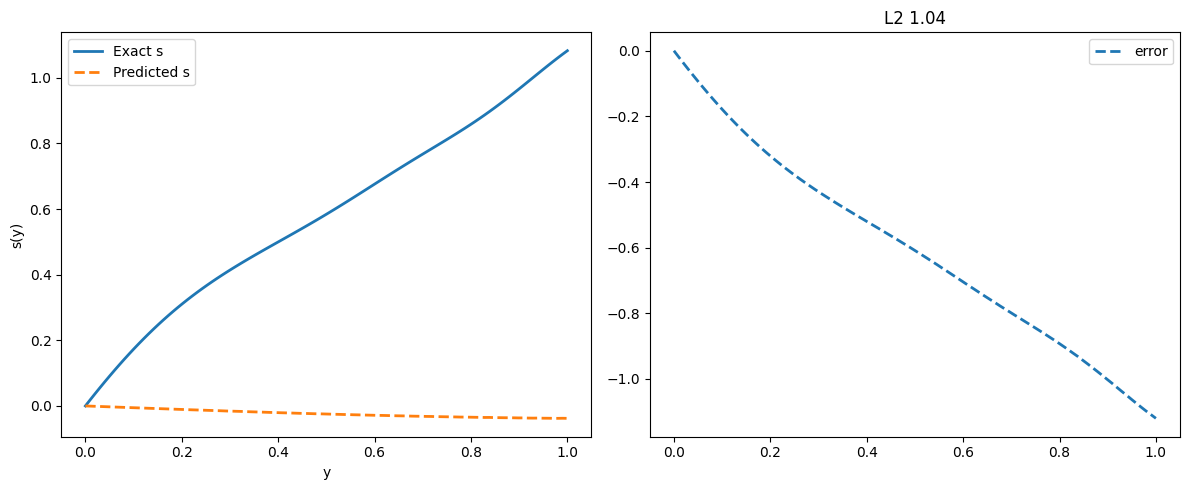

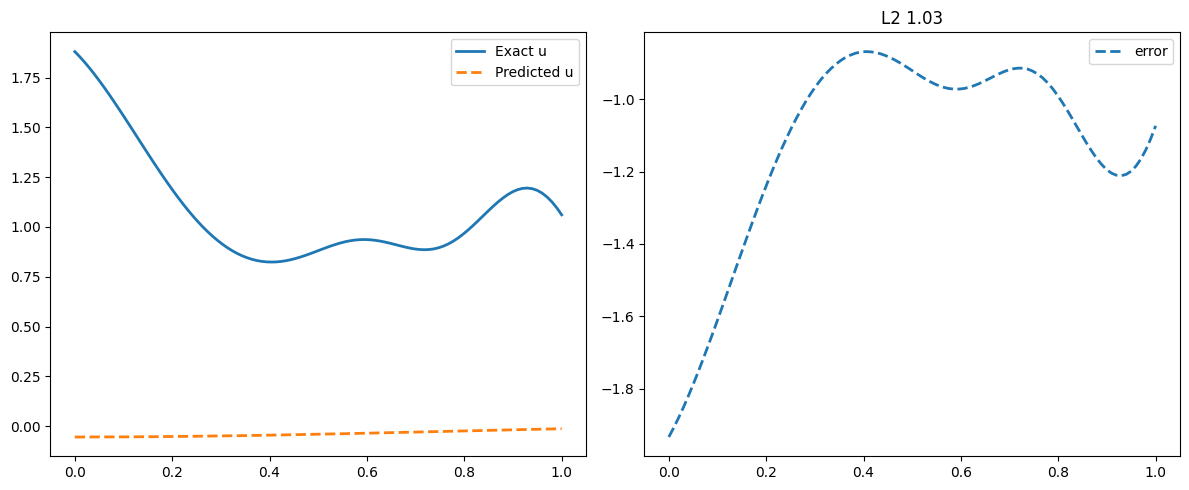

In [ ]:
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
l2_error = jnp.linalg.norm(s_test[index, :] - s_pred[index, :]) / jnp.linalg.norm(s_test[index, :])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], u_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], u_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
l2_error = jnp.linalg.norm(u_test[::P_test][idx] - u_pred[index,:].flatten()) / jnp.linalg.norm(u_test[::P_test][idx])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [ ]:
key_train = random.PRNGKey(0)
l_train = 0.2  
N_train = 10000
m_train = m
P_train = 1
Q_train = 100

u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = \
    generate_training_data(key_train, l_train, N_train, m_train, P_train, Q_train)

In [ ]:
y_train = jnp.zeros_like(y_train)
s_train = jnp.zeros_like(s_train)

In [ ]:
y_train, s_train

(Array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 Array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32))

In [ ]:
print(u_train.shape)
print(y_train.shape)
print(s_train.shape)
print(u_r_train.shape)
print(y_r_train.shape)
print(s_r_train.shape)

(10000, 100)
(10000, 1)
(10000, 1)
(1000000, 100)
(1000000, 1)
(1000000, 1)


In [ ]:
# Create data set
batch_size = 10000

operator_dataset = DataGenerator(u_train, y_train, s_train, batch_size)
physics_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [ ]:
# Train

model.train(operator_dataset, physics_dataset, nIter=40000)

100%|██████████| 40000/40000 [02:48<00:00, 238.06it/s, Loss=3.735542e-05, loss_operator=1.2496291e-07, loss_physics=3.7230457e-05]   


In [ ]:
path = os.path.abspath('./TrainedModel/pi_deeponet_only')
os.makedirs(path, exist_ok=True)

params_path = os.path.join(path, 'params.npy')
loss_path = os.path.join(path, 'loss.npy')
loss_operator_path = os.path.join(path, 'loss_operator.npy')
loss_physics_path = os.path.join(path, 'loss_physics.npy')

# Save the trained model
params = model.get_params(model.opt_state)
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
jnp.save(params_path, flat_params)
jnp.save(loss_path, model.loss_log)
jnp.save(loss_operator_path, model.loss_operator_log)
jnp.save(loss_physics_path, model.loss_physics_log)

# Restore the trained model
flat_params = jnp.load(params_path)
params = model.unravel_params(flat_params)

# Restore loss
loss = jnp.load(loss_path)
loss_operator = jnp.load(loss_operator_path)
loss_physics = jnp.load(loss_physics_path)

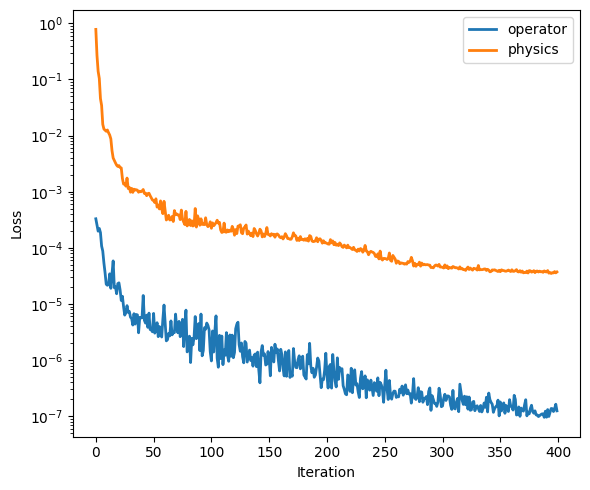

In [ ]:
plt.figure(figsize = (6,5))
plt.plot(loss_operator, lw=2, label='operator')
plt.plot(loss_physics, lw=2, label='physics')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# After training

In [ ]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:, None]
u_pred = model.predict_s_y(params, u_test, y_test)

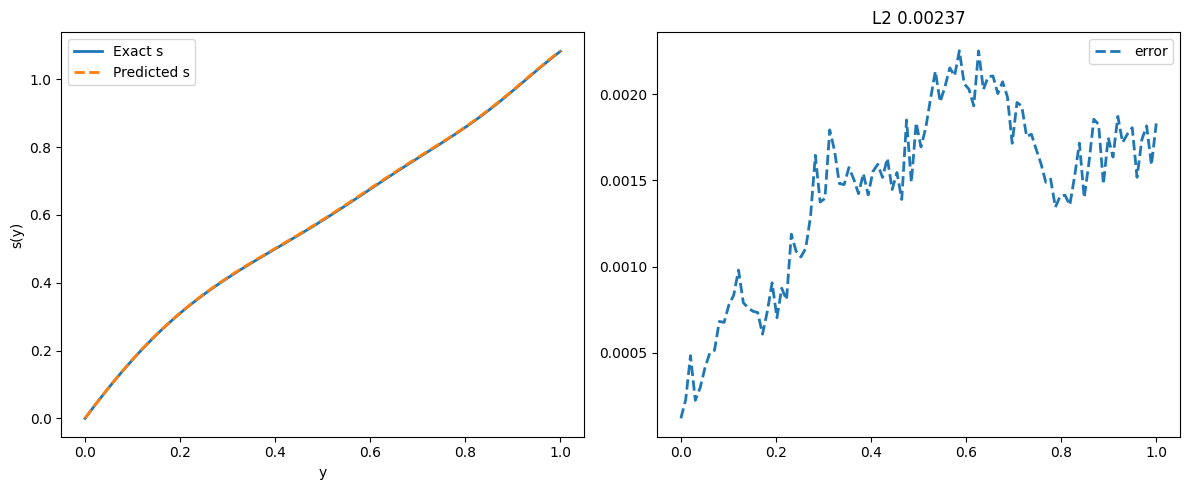

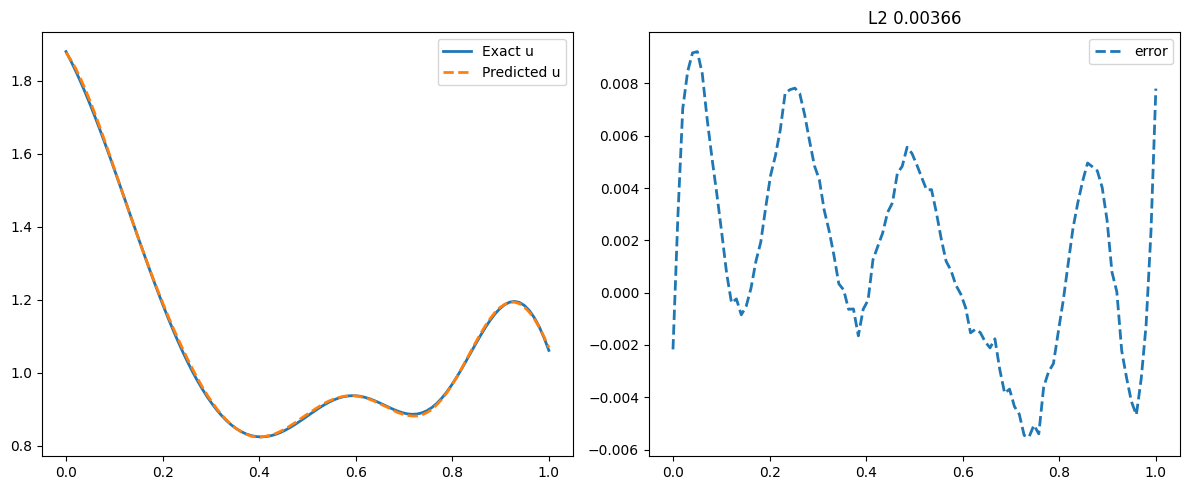

In [ ]:
# Predicted solution s(y)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], s_test[index, :], label='Exact s', lw=2)
plt.plot(y_test[index, :], s_pred[index, :], '--', label='Predicted s', lw=2)
plt.xlabel('y')
plt.ylabel('s(y)')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], s_pred[index, :] - s_test[index, :], '--', lw=2, label='error')
l2_error = jnp.linalg.norm(s_test[index, :] - s_pred[index, :]) / jnp.linalg.norm(s_test[index, :])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()

# Predicted residual u(x)
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_test[index, :], u_test[::P_test][idx], label='Exact u', lw=2)
plt.plot(y_test[index, :], u_pred[index,:], '--', label='Predicted u', lw=2)
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(y_test[index, :], u_pred[index,:].flatten() - u_test[::P_test][idx] , '--', label='error', lw=2)
l2_error = jnp.linalg.norm(u_test[::P_test][idx] - u_pred[index,:].flatten()) / jnp.linalg.norm(u_test[::P_test][idx])
plt.title(f"L2 {l2_error:.3g}")
plt.legend()
plt.tight_layout()
plt.show()